In [128]:
import sys
import os

# # Add the parent directory to sys.path
# parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
# sys.path.append(parent_dir)

# # Now you can import your module
# import my_module

# # Use the functions or classes from my_module
# result = my_module.some_function()
# print(result)


In [129]:
def clean_cashflow_data(cashflow_data):
    # Replace a special character in the first column
    cashflow_data.iloc[:, 0] = cashflow_data.iloc[:, 0].str.replace('∟', '', regex=True)

    # Replace non-breaking space and 'n.a.' with NaN
    cashflow_data.replace('\xa0', '', regex=True, inplace=True)
    cashflow_data.replace('n.a.', np.nan, inplace=True)

    # Drop columns where all values are NaN
    cashflow_data = cashflow_data.dropna(how='all', axis=1)

    # Drop rows with less than 10 non-NaN values
    cashflow_data = cashflow_data.dropna(thresh=10)

    return cashflow_data


def update_column_names(cashflow_data, base_year):
    # Calculate the number of years by subtracting one to exclude the 'Cash Metric' column
    number_of_years = cashflow_data.shape[1] - 1
    
    # Create a list of years in reverse order starting from the base year
    years = [str(base_year - i) for i in range(number_of_years)]
    
    # Update DataFrame column names
    cashflow_data.columns = ['Cash Metric'] + years
    
    # Strip whitespace from the 'Cash Metric' column
    cashflow_data['Cash Metric'] = cashflow_data['Cash Metric'].str.strip()
    
    return cashflow_data






In [130]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

# Import data into pandas DataFrame
# Assuming financial_data and store_counts are already loaded into pandas DataFrames
walmartPath="/Users/myself/Desktop/Walmart USA Searching for Growth/"



cashflow_data=pd.read_excel(walmartPath+"walmartCashFlow.xlsx",skiprows=15)

store_count=pd.read_excel(walmartPath+"walmartCashFlow.xlsx", "Yearly Store Count by Type",skiprows=2)
store_count.columns=store_count.columns.astype(str)

# cashflow_data,store_count
distribution_count=pd.read_excel(walmartPath+"walmartCashFlow.xlsx", "Yearly DC", skiprows=1)

cashflow_data.iloc[:,0]=cashflow_data.iloc[:,0].str.replace('∟', '', regex=True)

cashflow_data.replace('\xa0', '', regex=True, inplace=True)
cashflow_data.replace('n.a.', np.nan, inplace=True)

cashflow_data=cashflow_data.dropna(how='all',axis=1)
cashflow_data=cashflow_data.dropna(thresh=10)
cashflow_data


# Correctly identify and assign unique years to each financial data column
# Assuming the first column after 'Financial Metric' is the most recent year and decrement for each column after
number_of_years = cashflow_data.shape[1] - 1  # Total columns minus the 'Financial Metric' column
base_year = 2022
years = [str(base_year - i) for i in range(number_of_years)]

# # Map the new year labels to the columns
cashflow_data.columns = ['Cash Metric'] + years
cashflow_data['Cash Metric']=cashflow_data['Cash Metric'].str.strip()



statement_data=pd.read_excel(walmartPath+"walmartHistoricalFinancials.xlsx",skiprows=15)

statement_data = clean_cashflow_data(statement_data)
statement_data = update_column_names(statement_data,2021)

In [131]:
def pivot_year_columns_to_rows(df,column_names):
    df_pivot = df.pivot_table(values=df.columns[1:],columns=df[column_names])
    if column_names == "Year":
        df_pivot.columns.name="Columns"
        df_pivot.index.name="Year"
    else:
        df_pivot.index.name="Year"
    return df_pivot

cashflow_pivot=pivot_year_columns_to_rows(cashflow_data,'Cash Metric')  #cashflow_data.pivot_table(values=cashflow_data.columns,columns=cashflow_data['Cash Metric'])
cashflow_pivot=cashflow_pivot/1000

statement_pivot=pivot_year_columns_to_rows(statement_data,'Cash Metric')
statement_pivot=statement_pivot/1000


store_pivot=pivot_year_columns_to_rows(store_count,'Year')
store_pivot.rename(columns={"Total":"Total Store"},inplace=True)
store_pivot = store_pivot.shift(periods=0)

avg_store_sqft={'Supercenters': 182000, 'Neighborhood markets': 38000, 'Discount stores': 106000, 'Total Store': 1}
store_sqft=store_pivot*avg_store_sqft/1000
store_sqft['Total Store'] = store_sqft['Supercenters'] + store_sqft['Neighborhood markets'] + store_sqft['Discount stores']



# Prepare distribution centre table for merge
distribution_count.rename(columns={"Total":"Total DC","Total.1":"Total SqFt"},inplace=True)
dist_pivot=distribution_count.pivot_table(index='Year')
dist_pivot.index=dist_pivot.index.astype(str)

dist_pivot = dist_pivot.shift(periods=-5)
dist_pivot['Total SqFt Thousands'] = dist_pivot['Total SqFt']/1000



In [143]:

merge_data_left = pd.merge(cashflow_pivot, store_pivot, on='Year', how='left')
merge_data_left = pd.merge(merge_data_left, dist_pivot ,on='Year',how='left')
merge_data_left = pd.merge(merge_data_left, statement_pivot ,on='Year',how='left')



fin_merge_corr = merge_data_left.corr()
output_file_path = '/Users/myself/Desktop/Walmart USA Searching for Growth/Statement StoreDist Correlations.xlsx'
fin_merge_corr.to_excel(output_file_path, sheet_name='Correlations')



#sqft = merge_data_left[['Capital Expenditures','Total SqFt','Discount stores', 'Supercenters','Neighborhood markets','Total Store']]
#sqft.interpolate(inplace=True)

print(f'Financial Correlations saved to {output_file_path}')


Financial Correlations saved to /Users/myself/Desktop/Walmart USA Serching for Growth/Statement StoreDist Correlations.xlsx


In [144]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Visualize the relationship between Capex and Rolling SqFt
# sns.regplot(x='Total SqFt', y='Capital Expenditures', data=merge_data_left)
# plt.title('Rolling SqFt vs. Capital Expenditure')
# plt.show()

# sns.regplot(x='Total Store', y='Capital Expenditures', data=merge_data_left)
# plt.title('Store Change vs. Capital Expenditure')
# plt.show()



In [145]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from expertForecastFunctionsCopy1 import *

# Assuming 'data' is your DataFrame
# Convert all columns to numeric, setting errors='coerce' will convert non-convertible types to NaN



merge_left_numeric = merge_data_left.apply(pd.to_numeric, errors='coerce')
merge_left_numeric.index = pd.to_datetime(merge_left_numeric.index, format='%Y', errors='coerce')
merge_left_numeric.interpolate(method='linear',inplace=True)
merge_left_numeric['Neighborhood markets'] = merge_left_numeric['Neighborhood markets'].fillna(0)
merge_left_numeric.interpolate(method='linear', fill_value="extrapolate", limit_direction="both",inplace=True)
# Identifying indices with NaN values
nan_indices = merge_left_numeric[merge_left_numeric.isna().any(axis=1)].index
# print(nan_indices)

# Identifying columns with NaN values for each row
nan_details = merge_left_numeric.apply(lambda row: row.index[row.isna()].tolist(), axis=1)
# print(nan_details)



store_ratio=pd.DataFrame((merge_left_numeric['Discount stores']/merge_left_numeric['Supercenters']) * (merge_left_numeric['Discount stores']+merge_left_numeric['Supercenters']))
store_ratio.rename(columns={0:"Store ratio"},inplace=True)
merge_left_numeric=pd.merge(merge_left_numeric, store_ratio ,on='Year',how='left')

dist_pivot_reindex = pd.merge(pd.DataFrame(merge_data_left.index), dist_pivot ,on='Year',how='left')
dist_pivot_reindex.set_index('Year',inplace=True)
dist_pivot_reindex.ffill(inplace=True)
dist_pivot_reindex

,Center Point,Center Point.1,Crossdock,Crossdock.1,Distribution Center,Distribution Center.1,Food,Food Manufacture,Food Manufacture.1,Food.1,...,Sams eCommerce Dark.1,Specialty,Specialty.1,Total DC,Total SqFt,Vacated,Vacated.1,eCommerce,eCommerce.1,Total SqFt Thousands
Year,,,,,,,,,,,,,,,,,,,,,
1995,0.0,0.00,14.0,2665486.0,30.0,17945840.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,81.0,5.510610e+07,7.0,2685520.0,0.0,0.000000e+00,55106.097000
1996,0.0,0.00,16.0,2740886.0,35.0,19981009.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,95.0,6.242674e+07,9.0,2938934.0,0.0,0.000000e+00,62426.741000
1997,0.0,0.00,17.0,2800886.0,40.0,23479009.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,105.0,6.916474e+07,10.0,3358934.0,1.0,1.000000e+06,69164.741000
1998,0.0,0.00,17.0,2800886.0,47.0,28824027.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,113.0,7.570976e+07,10.0,3358934.0,1.0,1.000000e+06,75709.759000
1999,0.0,0.00,17.0,2800886.0,51.0,31023506.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,121.0,8.171444e+07,11.0,3424134.0,1.0,1.000000e+06,81714.438000
2000,0.0,0.00,17.0,2800886.0,55.0,37480350.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,128.0,9.182128e+07,11.0,3424134.0,1.0,1.000000e+06,91821.282000
2001,0.0,0.00,18.0,2926686.0,59.0,41470350.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,134.0,9.809708e+07,11.0,3424134.0,1.0,1.000000e+06,98097.082000
2002,0.0,0.00,18.0,2926686.0,60.0,42460350.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,136.0,1.002871e+08,11.0,3424134.0,1.0,1.000000e+06,100287.082000
2003,0.0,0.00,20.0,2986746.0,61.0,42685350.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,139.0,1.005721e+08,11.0,3424134.0,1.0,1.000000e+06,100572.142000


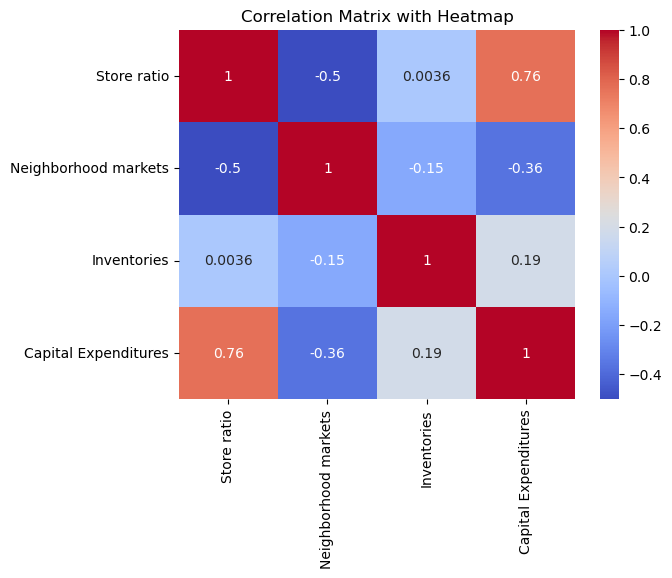

                feature       VIF
0           Store ratio  1.200601
1  Neighborhood markets  2.281726
2           Inventories  1.664408
3  Capital Expenditures  2.728971


In [146]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor



def analyze_correlations(variateDFT):
    # Creating a correlation matrix and displaying it as a heatmap
    corr_matrix = variateDFT.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix with Heatmap')
    plt.show()

    # Checking for multicollinearity using Variance Inflation Factor (VIF)
    vif_data = pd.DataFrame()
    vif_data["feature"] = variateDFT.columns
    vif_data["VIF"] = [variance_inflation_factor(variateDFT.values, i) for i in range(len(variateDFT.columns))]
    print(vif_data)


analyze_correlations(merge_left_numeric[['Store ratio','Neighborhood markets','Inventories', 'Capital Expenditures']])

### Beginning of PCA Work

Explained Variance Ratio: [6.17022907e-01 9.83989603e-02 5.72454490e-02 4.05967652e-02
 3.56824378e-02 2.58051666e-02 2.20307702e-02 1.90777504e-02
 1.81569922e-02 1.34243426e-02 1.07164602e-02 8.12169285e-03
 6.09449135e-03 5.29851510e-03 4.30050046e-03 3.75588165e-03
 2.78417923e-03 2.56988030e-03 2.27980708e-03 1.88570950e-03
 1.64260292e-03 1.00763084e-03 7.06973372e-04 5.57202111e-04
 3.72513029e-04 2.77492769e-04 1.86926389e-04 5.34328818e-33]
PCA Components: [[ 1.49214271e+01  3.62733187e+00 -6.51905165e-01  2.42071256e-01
  -2.25974690e+00  2.17987514e+00  5.59787489e-01  1.16900654e+00
  -2.50606925e+00 -1.04427393e+00 -7.05588915e-01  6.49041874e-01
   3.11405817e-01 -1.16307758e+00  2.24320656e-01  9.60369472e-01
  -5.50244239e-01 -2.23762611e-01  3.87765029e-01  6.46953546e-01
  -7.01509300e-01 -1.17357508e-01 -9.64522881e-02 -6.93881067e-02
  -2.36061422e-01 -9.57892528e-02 -1.80174381e-01 -6.93889390e-17]
 [ 1.37636002e+01  2.96999188e+00 -4.05004275e-01 -1.69096122e-01
 

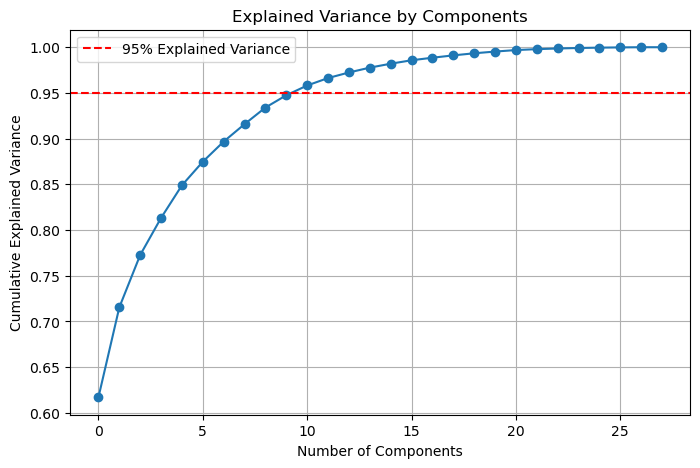

In [147]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(merge_left_numeric)

# Apply PCA
pca = PCA()
pca.fit(df_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

# Transform data
df_pca = pca.transform(df_scaled)
print("PCA Components:", df_pca)

loadings = pca.components_

# Create a DataFrame for better visualization of loadings
loadings_df = pd.DataFrame(loadings, columns=merge_left_numeric.columns, index=[f'PC{i+1}' for i in range(len(loadings))])
print(loadings_df)
loadings_df.to_excel(walmart_path+'PCA Components.xlsx',sheet_name='loadings')

import matplotlib.pyplot as plt

# Assuming 'explained_variance' is your array of explained variance ratios from PCA
cumulative_variance = np.cumsum(explained_variance)
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend(loc='best')
plt.grid(True)
plt.show()


### Switching from PCA to PLS with Distribution SqFt as response variable

In [148]:
data = pd.DataFrame(df_pca

In [149]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

warnings.filterwarnings("ignore")  # Suppress warnings

def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

def remove_high_vif(data, threshold=100.0):
    data = data.copy()
    while True:
        vif_data = calculate_vif(data)
        max_vif = vif_data["VIF"].max()
        if max_vif > threshold and len(data.columns) > 28 or max_vif == float('inf'):
            drop_variable = vif_data.loc[vif_data["VIF"] == max_vif, "Variable"].values[0]
            data = data.drop(columns=[drop_variable])
            print(f"Dropped {drop_variable} with VIF {max_vif}")
        else:
            break
    return data

# Example usage:
# data = pd.DataFrame(...)
# cleaned_data = remove_high_vif(data)


In [150]:

# Recalculate VIF
vif_data = calculate_vif(data)
print(vif_data)


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [107]:
data_reduced = remove_high_vif(data)

Dropped Accounts Payable with VIF inf
Dropped Accounts Receivable with VIF inf
Dropped Accrued Expenses with VIF inf
Dropped Acquisition of Business with VIF inf
Dropped Capital Expenditures with VIF inf
Dropped Cash Dividends Paid - Common with VIF inf
Dropped Cash Interest Paid, Supplemental with VIF inf
Dropped Cash Taxes Paid, Supplemental with VIF inf
Dropped Changes in Working Capital with VIF inf
Dropped Common Stock, Net with VIF inf
Dropped Deferred Taxes with VIF inf
Dropped Depreciation with VIF inf
Dropped Depreciation, Supplemental with VIF inf
Dropped Depreciation/Depletion with VIF inf
Dropped Discontinued Operations with VIF inf
Dropped Financing Cash Flow Items with VIF inf
Dropped Foreign Exchange Effects with VIF inf
Dropped Inventories with VIF inf
Dropped Issuance (Retirement) of Debt, Net with VIF inf
Dropped Issuance (Retirement) of Stock, Net with VIF inf
Dropped Long Term Debt Issued with VIF inf
Dropped Long Term Debt Reduction with VIF inf
Dropped Long Term D

In [108]:
calculate_vif(data_reduced)

,Variable,VIF
0,Total Store,7.700854e+08
1,EBITDA,4.364418e+10
2,Enterprise value,3.615933e+06
3,Financial expenses,8.176728e+08
4,Financial revenue,1.053282e+07
5,Interest paid,1.437447e+05
6,Non-current assets,3.602527e+07
7,Non-current liabilities,1.006437e+06
8,Number of employees,8.508211e+07
9,Of which cash and cash equivalent,8.554517e+07


In [121]:
# Step 1: Load Libraries and Define Utility Functions
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Function to clean cashflow data
def clean_cashflow_data(cashflow_data):
    cashflow_data.iloc[:, 0] = cashflow_data.iloc[:, 0].str.replace('∟', '', regex=True)
    cashflow_data.replace('\\xa0', '', regex=True, inplace=True)
    cashflow_data.replace('n.a.', np.nan, inplace=True)
    cashflow_data = cashflow_data.dropna(how='all', axis=1)
    cashflow_data = cashflow_data.dropna(thresh=10)
    return cashflow_data

# Function to update column names
def update_column_names(cashflow_data, base_year):
    number_of_years = cashflow_data.shape[1] - 1
    years = [str(base_year - i) for i in range(number_of_years)]
    cashflow_data.columns = ['Cash Metric'] + years
    cashflow_data['Cash Metric'] = cashflow_data['Cash Metric'].str.strip()
    return cashflow_data

# Function to pivot year columns to rows
def pivot_year_columns_to_rows(df, column_names):
    df_pivot = df.pivot_table(values=df.columns[1:], columns=df[column_names])
    if column_names == "Year":
        df_pivot.columns.name = "Columns"
        df_pivot.index.name = "Year"
    else:
        df_pivot.index.name = "Year"
    return df_pivot

# Function to perform PLS regression with cross-validation
def perform_pls_regression(X, Y, n_components=len(pca_data.columns), n_splits=5):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pls = PLSRegression(n_components=n_components)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = cross_val_score(pls, X_scaled, Y, cv=kf, scoring='neg_mean_squared_error')
    average_mse = -np.mean(cv_scores)
    pls.fit(X_scaled, Y)
    return pls, average_mse

# Function to plot PLS loadings
def plot_pls_loadings(pls, feature_names):
    loadings = pls.x_weights_
    loadings_df = pd.DataFrame(loadings, columns=[f'Component {i+1}' for i in range(loadings.shape[1])], index=feature_names)
    plt.figure(figsize=(12, 8))
    sns.heatmap(loadings_df, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('PLS Component Loadings')
    plt.xlabel('Components')
    plt.ylabel('Variables')
    plt.show()

# Function to perform PCA for dimensionality reduction
def perform_pca(data, n_components=0.95):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data_scaled)
    explained_variance = pca.explained_variance_ratio_.sum()
    print(f"Explained variance by selected components: {explained_variance}")
    return pd.DataFrame(principal_components)


In [123]:
# Calculate variance of each variable
variances = data_reduced.var()

# Identify variables with near zero variance
near_zero_var = [col for col in data_reduced.columns if variances[col] < 1e-5]

# Drop variables with near zero variance
data.drop(near_zero_var, axis=1, inplace=True)

print(f"Variables with near zero variance removed: {near_zero_var}")


Variables with near zero variance removed: []


Explained variance by selected components: 0.952005632854073
           0         1         2         3
0   8.067956  1.563029 -0.682242  0.035180
1   7.497490  1.060904 -0.581342  0.203766
2   7.120937  1.081541 -0.303463  0.098692
3   6.635344  1.133028 -0.154809 -0.048676
4   6.152529  0.844525 -0.046001 -0.194246
5   5.085745  0.526778  0.040517 -0.108091
6   4.391514  0.315548  0.083543  0.086849
7   4.028289  0.101925 -0.259873  0.239263
8   3.378434 -0.395939 -0.747293  0.154217
9   2.537291 -0.375909 -0.236632 -0.395776
10  1.605663 -0.943924  0.295884 -0.555189
11  0.666823 -1.183250  1.007953 -0.707214
12 -0.253242 -1.390108  1.880637 -0.685410
13 -0.979877 -1.743912  2.291542 -0.416859
14 -1.365539 -1.970339  1.829510 -0.460577
15 -1.997180 -1.338605  0.509910 -0.304837
16 -2.477246 -1.790961  0.550100 -0.343590
17 -3.118757 -1.904000 -0.393770  0.105833
18 -3.732431 -2.237217 -0.447418 -0.304719
19 -3.842866 -2.032561 -1.723086  0.232043
20 -4.132970 -1.793676 -1.855408  0.

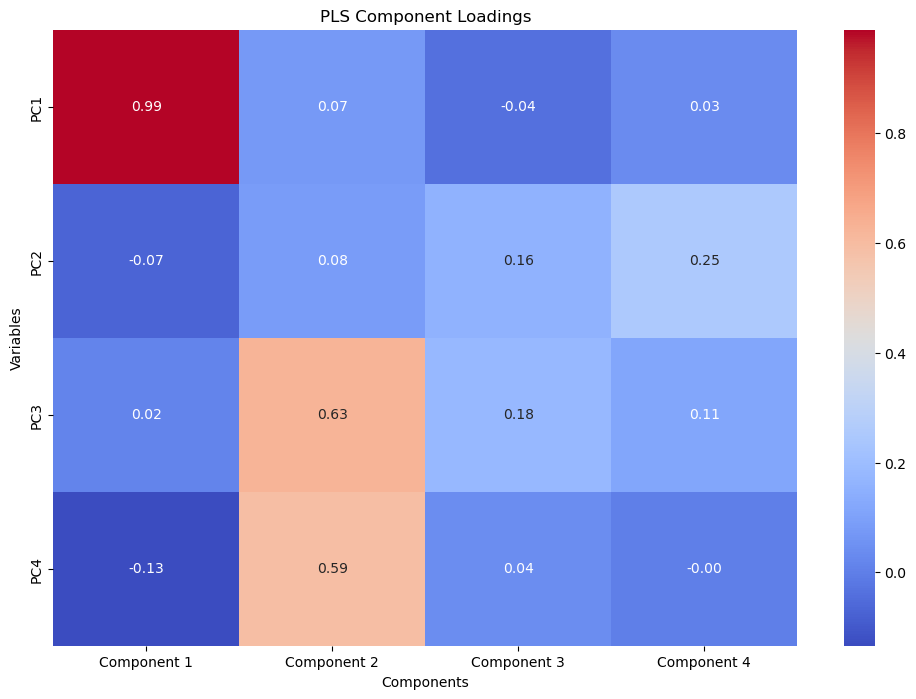

In [124]:


# Step 1: Load Libraries and Define Utility Functions
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from sklearn.model_selection import cross_val_score, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


# Function to perform PCA for dimensionality reduction
def perform_pca(data, n_components=0.95):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data_scaled)
    explained_variance = pca.explained_variance_ratio_.sum()
    print(f"Explained variance by selected components: {explained_variance}")
    return pd.DataFrame(principal_components)

# Step 2: Load and Clean Data (assuming data is loaded in previous steps)

# # Step 3: Calculate and Reduce VIF
# data_reduced = merge_left_numeric.dropna()  # Ensure no NaN values
# data_double_reduced = remove_high_vif(data_reduced)
# print("Remaining variables after VIF reduction:\n", data_double_reduced.columns)
# vif_data = calculate_vif(data_double_reduced)
# print(vif_data)

# Step 4: Perform PCA for Dimensionality Reduction
pca_data = perform_pca(data_reduced)
print(pca_data)

# Step 5: Perform PLS Regression
Y = dist_pivot_reindex['Total SqFt Thousands']  # Your target variable
pls, avg_mse = perform_pls_regression(pca_data, Y)
print("Average MSE:", avg_mse)

# Plot PLS loadings
# Note: For PCA data, use PCA components instead of original feature names
plot_pls_loadings(pls, feature_names=[f'PC{i+1}' for i in range(pca_data.shape[1])])


In [58]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
if 'Total Sqft' in merge_left_numeric.columns:
    merge_left_numeric=merge_left_numeric.drop('Total SqFt', axis=1)
    
# Example Data
X = data_double_reduced  # assuming 'DependentVariable' is your dependent variable
Y = dist_pivot_reindex['Total SqFt Thousands']

# Standardize the data (important for modeling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
Y_scaled = scaler.fit_transform(Y.values.reshape(-1, 1)).flatten()

# PLS model
pls = PLSRegression(n_components=6)  # You can adjust the number of components
pls.fit(X_scaled, Y_scaled)

# Viewing the components
print("PLS Components (Weights for each feature in components):")
print(pls.x_weights_)

# Transform data
X_pls = pls.transform(X_scaled)


PLS Components (Weights for each feature in components):
[[-0.40305718  0.22980185 -0.18602966  0.04380208 -0.21695095  0.83734261]
 [ 0.21419339  0.10645126 -0.39536331  0.76211645  0.44915711  0.06255857]
 [-0.43143048  0.35393524  0.722966    0.33394967  0.2066575  -0.10811125]
 [-0.51581246  0.02862164 -0.34060399 -0.410217    0.65501813 -0.14064314]
 [ 0.22297926 -0.58549456  0.39898998 -0.08391408  0.45916065  0.48001384]
 [ 0.5382858   0.68334911  0.10581538 -0.36113425  0.26192672  0.18182945]]


### End of Auto Drop PLS Attempt

### Beginning of analysing original Variable relevance to PLS model 

[1.9765897  0.14373277 0.03028363 0.26742656]
            VIP Score
Variable 1    1.97659


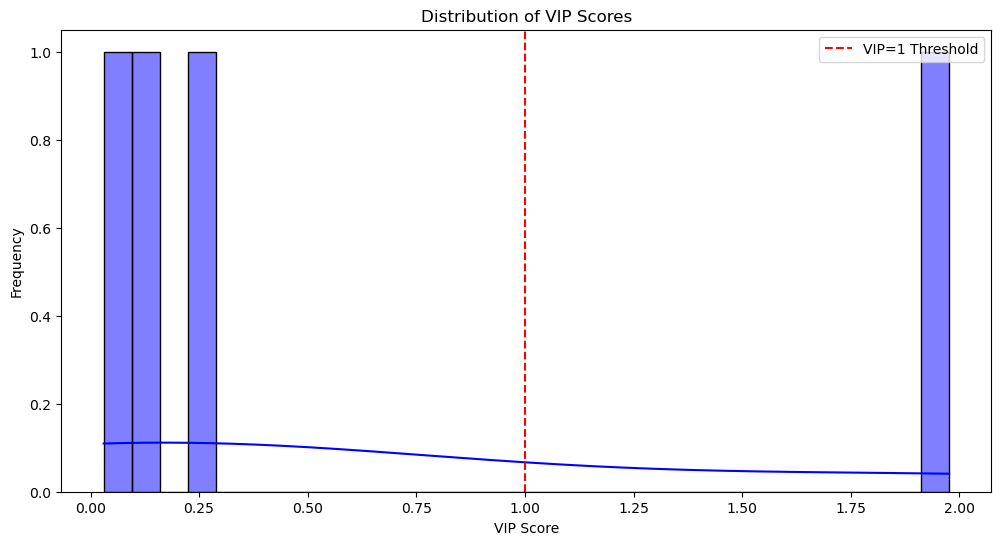

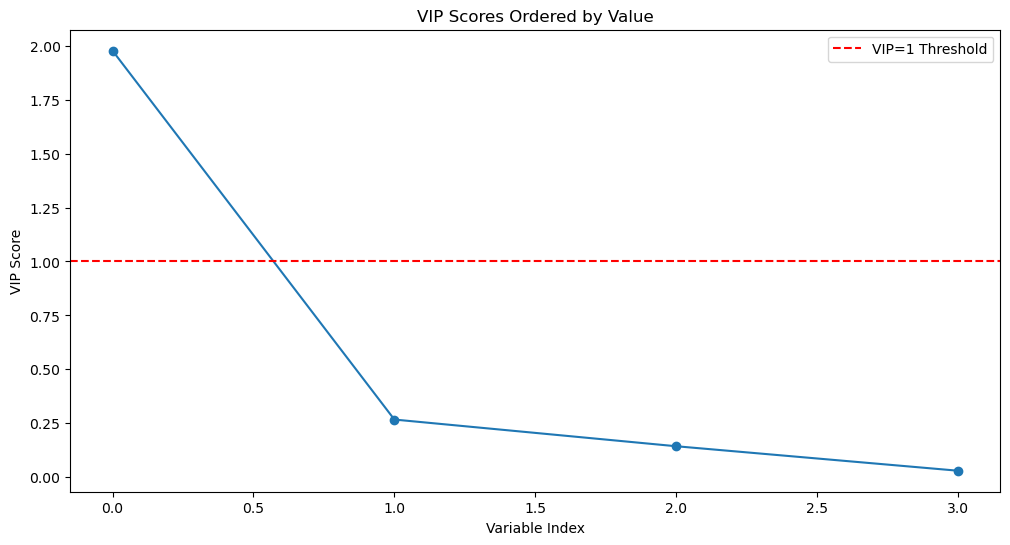

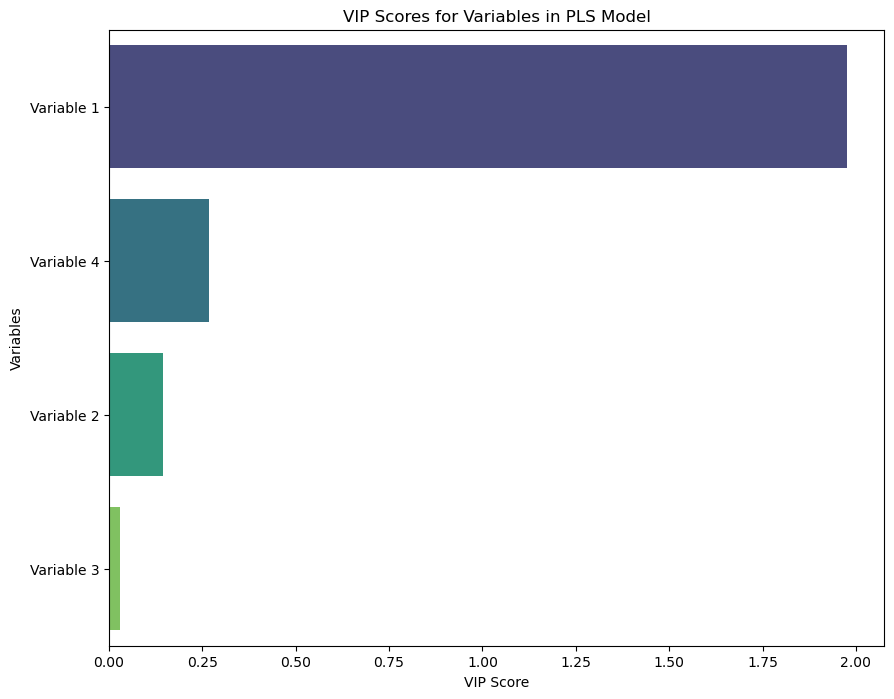

1

In [125]:
import numpy as np

def calculate_vip(pls_model):
    t = pls_model.x_scores_  # Scores
    w = pls_model.x_weights_  # Weights
    q = pls_model.y_loadings_  # Y loadings
    
    p, h = w.shape
    vips = np.zeros((p,))
    
    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)
    
    for i in range(p):
        weight = np.array([(w[i, j] / np.linalg.norm(w[:, j]))**2 * s[j] for j in range(h)])
        vips[i] = np.sqrt(p * np.sum(weight) / total_s)
        
    return vips

# Assume 'pls' is your fitted PLS model
vip_scores = calculate_vip(pls)
print(vip_scores)


import numpy as np
import pandas as pd

# Create a DataFrame for better visualization and manipulation
variables = [f'Variable {i+1}' for i in range(len(vip_scores))]
vip_df = pd.DataFrame({'VIP Score': vip_scores}, index=variables)

# Sort the DataFrame to see the most important variables at the top
vip_df_sorted = vip_df.sort_values(by='VIP Score', ascending=False)

# Filter to find highly influential variables
key_variables = vip_df_sorted[vip_df_sorted['VIP Score'] > 1]

key_variables.to_excel('/Users/myself/Desktop/Walmart USA Searching for Growth/keyVarStoreDistCash.xlsx')
print(key_variables)  # This will display the variables with VIP scores greater than 1

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming vip_scores is a numpy array of your VIP scores
plt.figure(figsize=(12, 6))
sns.histplot(vip_scores, bins=30, kde=True, color='blue')
plt.title('Distribution of VIP Scores')
plt.xlabel('VIP Score')
plt.ylabel('Frequency')
plt.axvline(x=1, color='red', linestyle='--', label='VIP=1 Threshold')
plt.legend()
plt.show()

# Additionally, you might want to plot them in a sorted manner
sorted_scores = np.sort(vip_scores)[::-1]  # Sort descending
plt.figure(figsize=(12, 6))
plt.plot(sorted_scores, marker='o')
plt.title('VIP Scores Ordered by Value')
plt.xlabel('Variable Index')
plt.ylabel('VIP Score')
plt.axhline(y=1, color='red', linestyle='--', label='VIP=1 Threshold')
plt.legend()
plt.show()


import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the VIP scores
plt.figure(figsize=(10, 8))
sns.barplot(x='VIP Score', y=vip_df_sorted.index, data=vip_df_sorted, palette='viridis')
plt.title('VIP Scores for Variables in PLS Model')
plt.xlabel('VIP Score')
plt.ylabel('Variables')
plt.show()

len(key_variables)

### Beginning of Domain Knowledge Variable reduction for PLS Simplicity

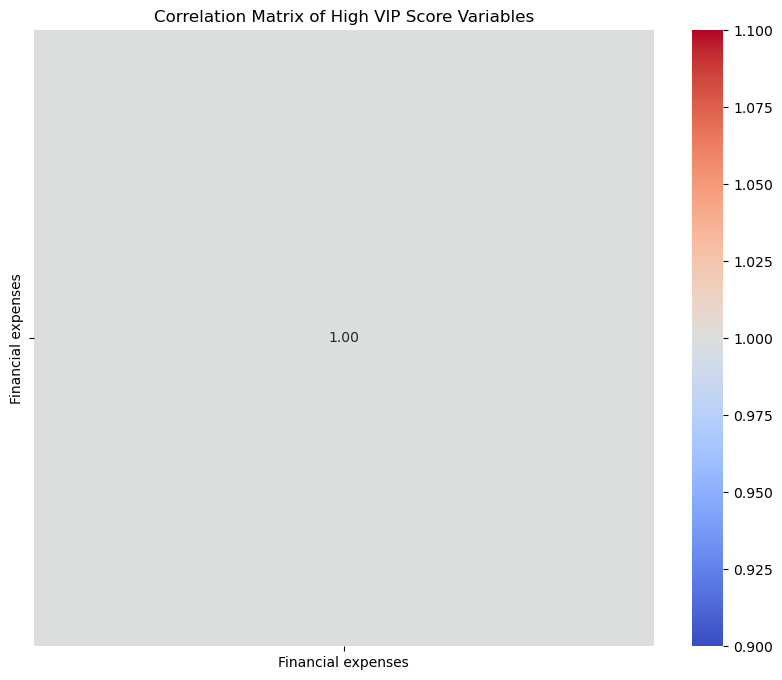

Empty DataFrame
Columns: [Variable 1, Variable 2, Correlation]
Index: []


ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1200x1000 with 0 Axes>

In [126]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume 'data' is your DataFrame and 'vip_scores' contains the VIP scores as a numpy array
high_vip_indices = np.where(vip_scores > 1)[0]
high_vip_data = X.iloc[:, high_vip_indices]

# Calculate correlation matrix
corr_matrix = high_vip_data.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of High VIP Score Variables')
plt.show()

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'high_vip_data' is already defined and contains data from high VIP score variables
corr_matrix = high_vip_data.corr()

# Set a threshold for high correlations (e.g., above 0.7 or 0.8)
threshold = 0.8

# Filter the correlation matrix
high_corr = corr_matrix[abs(corr_matrix) > threshold]

selfcorrelations=high_corr[high_corr == 1].stack()

# Remove self-correlations and duplicates
high_corr = high_corr[high_corr != 1].stack().drop_duplicates()

# Create a DataFrame from the filtered correlations for easier handling
high_corr_df = pd.DataFrame(high_corr, columns=['Correlation'])
high_corr_df = high_corr_df.reset_index()
high_corr_df.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Sort by absolute correlation value for better readability
high_corr_df['Abs Correlation'] = high_corr_df['Correlation'].abs()
high_corr_df = high_corr_df.sort_values(by='Abs Correlation', ascending=False)

# Display the sorted DataFrame
print(high_corr_df[['Variable 1', 'Variable 2', 'Correlation']])

# Optional: Plot a subset of the matrix with high correlations
# Select variables to display based on high correlation pairs
variables_to_plot = list(set(high_corr_df['Variable 1']).union(set(high_corr_df['Variable 2'])))
reduced_corr_matrix = high_vip_data[variables_to_plot].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(reduced_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Reduced Correlation Matrix of High VIP Score Variables')
plt.show()

correlationInventoryList = high_corr_df[['Variable 1', 'Variable 2', 'Correlation']]
correlationInventoryList.to_excel('/Users/myself/Desktop/Walmart USA Searching for Growth/correlationInventoryList.xlsx')



In [ ]:
variables_to_drop = set()

for var1, var2 in zip(high_corr_df['Variable 1'], high_corr_df['Variable 2']):
    if var1 not in variables_to_drop and var2 not in variables_to_drop:
        # Add var2 to the drop list; you could choose var1 instead based on your criteria
        variables_to_drop.add(var)

print("Columns to drop:", variables_to_drop)
len(variables_to_drop)
#high_vip_data_reduced = high_vip_data.drop(columns=list(variables_to_drop))


In [ ]:
type(selfcorrelations)
selfcorrdf=selfcorrelations.unstack()

metriccount=[]
for metric in selfcorrdf.index:
    currcount=selfcorrdf.loc[metric] == 1.0
    metriccount.append(currcount)


In [ ]:
# metric_count = []

# # Iterate over each metric in the DataFrame index
# for metric in selfcorrdf.index:
#     # Find the metrics that have a correlation of 1.0 with the current metric
#     correlated_metrics = selfcorrdf.columns[selfcorrdf.loc[metric] == 1.0].tolist()
    
#     # Append a tuple of the metric and its correlated metrics to the list
#     metric_count.append((metric, correlated_metrics))


In [ ]:
# for dex, val in enumerate(X.columns):
#     print(dex)


### Reducing PLS reliance to only high VIP (Variable Importance Power?) set

In [127]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(high_vip_data)  # Use only high VIP score variables
Y = dist_pivot_reindex['Total SqFt Thousands']  # Your target variable

# Define PLS model
pls = PLSRegression(n_components=3)  # Adjust based on your previous analysis

# Setup cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(pls, X_scaled, Y, cv=kf, scoring='neg_mean_squared_error')

# Average MSE
average_mse = -np.mean(cv_scores)
print("Average MSE:", average_mse)


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/myself/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/myself/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py", line 643, in fit
    super().fit(X, Y)
  File "/Users/myself/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/myself/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py", line 256, in fit
    raise ValueError(
ValueError: `n_components` upper bound is 1. Got 3 instead. Reduce `n_components`.


In [64]:
122092179.96844144**(1/2)

11049.5330203788

In [ ]:
27846226.980349492 - 158734981.76158053 

### Trying to interpret which combination of variables proprotionally construct the end number of PLS components. 

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

# Extracting loadings
loadings = pls.x_weights_  # Change to your variable name if different

# Creating a DataFrame for better visualization
loadings_df = pd.DataFrame(loadings, columns=[f'Component {i+1}' for i in range(loadings.shape[1])], index=[f'Variable {i+1}' for i in range(loadings.shape[0])])

# Plotting loadings
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('PLS Component Loadings')
plt.xlabel('Components')
plt.ylabel('Variables')
plt.show()

import pandas as pd

# Assume 'pls' is your fitted PLS model
loadings = pls.x_weights_  # Extract loadings from PLS model

# Create a DataFrame of loadings
loadings_df = pd.DataFrame(loadings, 
                           columns=[f'Component {i+1}' for i in range(loadings.shape[1])],
                           index=[f'Variable {i+1}' for i in range(loadings.shape[0])])

# Order the DataFrame by the absolute values of loadings for the first component as an example
# You can repeat this for each component or adapt as necessary
component = 'Component 1'  # Choose which component to sort by
ordered_loadings_df = loadings_df.iloc[:, loadings_df.columns.get_loc(component)].abs().sort_values(ascending=False)

# Display the ordered DataFrame
print(ordered_loadings_df)


import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the ordered loadings for the first component
sns.barplot(x=ordered_loadings_df.values, y=ordered_loadings_df.index)
plt.title(f'Loadings Ordered by {component}')
plt.xlabel('Loadings')
plt.ylabel('Variables')
plt.show()




### Considering how many componenets to generate for the PLS fit

In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize PLS with 10 components
pls = PLSRegression(n_components=10)

# Define MSE scorer
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform cross-validation
cv_scores = cross_val_score(pls, X_scaled, Y_scaled, cv=kf, scoring=mse_scorer)

# Calculate average MSE
average_mse = np.mean(-cv_scores)
print("Average MSE:", average_mse)

import matplotlib.pyplot as plt

mse_results = []
component_range = range(1, 11)  # Assuming you want to test from 1 to 10 components

for n in component_range:
    pls = PLSRegression(n_components=n)
    scores = cross_val_score(pls, X_scaled, Y_scaled, cv=kf, scoring=mse_scorer)
    mse_results.append(-np.mean(scores))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(component_range, mse_results, marker='o')
plt.title('MSE vs. Number of PLS Components')
plt.xlabel('Number of Components')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

component_range, mse_results

### End of PCA / PLS work

In [ ]:

# df=variateDFT
# # Assuming 'df' contains your data with columns 'Year', 'Net_Income', and 'Capex'
# X = sm.add_constant(df['Net Income'])  # Adds a constant term to the predictor
# y = df['Capital Expenditures']

# model = sm.OLS(y, X).fit()
# df['Capex_Residual'] = model.resid  # Calculate and store residuals

# # Review model summary to validate the linear relationship
# print(model.summary())

import pandas as pd
import statsmodels.api as sm

def analyze_capex_relationship(data, net_income_col, capex_col):
    # Add a constant term to the predictor for the linear regression model
    #X = sm.add_constant(data[net_income_col])
    X = data[net_income_col]
    y = data[capex_col]

    # Fit the linear regression model
    model = sm.OLS(y, X).fit()
    
    # Calculate and store residuals in the DataFrame
    data['Capex Residual '+net_income_col] = model.resid

    # Print the summary of the model to review the linear relationship
    print(model.summary())

    return data


# analyze_capex_relationship(merge_left_select, 'Net Income', 'Capital Expenditures')
# analyze_capex_relationship(merge_left_select, 'Total Store', 'Capital Expenditures')
# analyze_capex_relationship(merge_left_select, 'Total SqFt Thousands', 'Capital Expenditures')


import pandas as pd
import statsmodels.api as sm

def perform_ols_regression(data, predictors, response):
    """
    Performs a multivariable OLS regression.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing the dataset.
    - predictors (list of str): The names of the predictor columns.
    - response (str): The name of the response column.

    Returns:
    - model_summary (str): A summary of the regression model.
    """
    # Selecting predictors and adding a constant for the intercept
    X = data[predictors]
    #X = sm.add_constant(X)

    # Selecting the response variable
    y = data[response]

    # Creating and fitting the OLS model
    model = sm.OLS(y, X).fit()

    # Returning the summary of the model
    return model

model1= perform_ols_regression(merge_left_numeric,['Total SqFt Thousands'], 'Capital Expenditures')
model2= perform_ols_regression(merge_left_numeric,['Store ratio','Neighborhood markets','Inventories','Depreciation'], 'Total SqFt Thousands')


#merge_left_numeric['Store ratio'],merge_left_numeric['Total Store'],merge_left_numeric['Discount stores'],merge_left_numeric['Supercenters'],merge_left_numeric['Neighborhood markets'],merge_left_numeric['Total SqFt Thousands']

#print(merge_left_numeric.columns.tolist())

In [ ]:
model1.summary()

In [ ]:
model2.summary()

In [ ]:
# def analyze_capex_store_relationship(financial_data, store_counts):
#     # Extracting CapEx data and the relevant years
#     capex_data = financial_data[financial_data['Cash Metric'].isin(['Purchase of Fixed Assets', 'Capital Expenditures'])]
#     print(f"Before transposition: {capex_data.shape}")  # Check the shape before transposition
#     print(capex_data)  # View the content
    
#     capex_data = capex_data.drop('Cash Metric', axis=1).transpose()  # Transpose to make the years as rows
#     print(f"After transposition: {capex_data.shape}")  # Check the shape after transposition
#     print(capex_data)  # View the content
    
#     # Ensure that we have exactly two rows for 'Purchase of Fixed Assets' and 'Capital Expenditures'
#     if capex_data.shape[0] == 2:
#         capex_data.columns = ['Purchase of Fixed Assets', 'Capital Expenditures']
#     else:
#         raise ValueError("The CapEx data does not have the expected number of rows after transposition.")
    
#     # ... rest of the original function ...
    
#     return capex_data  # Temporarily return this to check the output

# # Call the function with the data
# capex_data_checked = analyze_capex_store_relationship(cashflow_data, store_count)


In [ ]:
# import pandas as pd


# def preprocess_store_counts(store_counts):
#     # Ensure all data is numeric, converting non-numeric to NaN
#     store_counts = store_counts.apply(pd.to_numeric, errors='coerce')

#     # Calculate net change in stores per year for each type of store
#     store_counts_diff = store_counts.diff(axis=1)  # Calculate year-over-year difference
#     store_counts_diff = store_counts_diff.iloc[:, 1:]  # Exclude the first column as it will be NaN after diff
    
#     return store_counts_diff

# # Re-run the preprocessing with corrected data types
# # store_counts_diff = preprocess_store_counts(store_count)

# # Optionally, you can check if there are many NaNs, which might indicate many non-numeric entries
# # print(store_counts_diff.isna().sum())

# def correlate_capex_changes(store_counts_diff, financial_data):
#     # Focus on Capital Expenditures for simplicity
#     capex_data = financial_data.loc[financial_data['Cash Metric'].isin(['Capital Expenditures'])]
#     capex_data = capex_data.drop('Cash Metric', axis=1).transpose()
#     capex_data.columns = ['Capital Expenditures']  # Set proper column name after transpose

#     # Ensure data types are correct for analysis
#     capex_data = capex_data.astype(float)  # Convert CapEx data to float for calculations
#     store_counts_diff = store_counts_diff.astype(float)  # Also ensure store count diffs are float

#     # Align the indices of both DataFrames to ensure they match for correlation analysis
#     # Both should have years as indices and be aligned accordingly
#     if not capex_data.index.equals(store_counts_diff.columns):
#         # Assuming both indices are years and formatted similarly
#         # This step might need adjustment based on actual index formats
#         capex_data = capex_data.reindex(store_counts_diff.columns)
#         print(store_counts_diff)
#         store_counts_diff=store_counts_diff.T
#         store_counts_diff=store_counts_diff.shift(periods=-1)
#         store_counts_diff=store_counts_diff.T
#         print(store_counts_diff)
#     # Compute correlation matrix
#     correlation_matrix = pd.concat([capex_data.iloc[::-1], store_counts_diff.loc[3]], axis=1).corr()
#     print(capex_data)
#     return correlation_matrix

# # Assuming 'cashflow_data' and 'store_count' are your DataFrames loaded correctly
# store_counts_diff = preprocess_store_counts(store_count)

# correlation_results = correlate_capex_changes(store_counts_diff, cashflow_data)

# # Output results
# print(correlation_results)
# store_count_total=store_count.loc[3]

In [ ]:

# # def correlate_capex_changes(store_counts_diff, financial_data):
# #     # Focus on Capital Expenditures for simplicity
# capex_data = cashflow_data.loc[cashflow_data['Cash Metric'].isin(['Capital Expenditures'])]
# capex_data = capex_data.drop('Cash Metric', axis=1).transpose()
# capex_data.columns = ['Capital Expenditures']  # Set proper column name after transpose
# capex_data.index
# print(capex_data)
# dist_counts_diff = preprocess_store_counts(totaldist_count.T)
# dist_counts_diffT=dist_counts_diff.T
# dist_counts_diffT=dist_counts_diffT.shift(periods=-5)
# dist_counts_diffT.index=dist_counts_diffT.index.astype('string')
# print(dist_counts_diffT)


# dist_counts_diffT = dist_counts_diffT.loc[dist_counts_diffT.index.isin(capex_data.index)]
# #dist_counts_diffT
# correlation_matrix = pd.concat([capex_data, dist_counts_diffT], axis=1).corr()
# correlation_matrix


#     # # Ensure data types are correct for analysis
#     # capex_data = capex_data.astype(float)  # Convert CapEx data to float for calculations
#     # store_counts_diff = store_counts_diff.astype(float)  # Also ensure store count diffs are float

#     # # Align the indices of both DataFrames to ensure they match for correlation analysis
#     # # Both should have years as indices and be aligned accordingly
#     # if not capex_data.index.equals(store_counts_diff.columns):
#     #     # Assuming both indices are years and formatted similarly
#     #     # This step might need adjustment based on actual index formats
#     #     #capex_data = capex_data.reindex(store_counts_diff.columns)
#     #     store_counts_diff=store_counts_diff.loc[store_counts['Cash Metric'].isin(['Capital Expenditures'])]
#     #     store_counts_diff=store_counts_diff.reindex(capex_data.index)
#     #     store_counts_diff=store_counts_diff.T
#     #     #print(store_counts_diff)
#     # # Compute correlation matrix
#     # correlation_matrix = pd.concat([capex_data, store_counts_diff], axis=1).corr()
#     # return correlation_matrix

# # Assuming 'cashflow_data' and 'store_count' are your DataFrames loaded correctly

# # correlation_results = correlate_capex_changes(dist_counts_diff, cashflow_data)

# # Output results
# #print(correlation_results)


In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# def expanded_correlation_analysis(financial_data, metrics_list):
#     # Filter for relevant metrics
#     relevant_data = financial_data[metrics_list]
#     # Calculate correlations
#     correlation_matrix = relevant_data.corr()
    
#     # Plot the correlation matrix
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
#     plt.title('Correlation Matrix for Financial Metrics')
#     plt.show()

#     return correlation_matrix

# # Define the list of metrics to include in the analysis
# metrics_to_analyze = [
#     'Capital Expenditures',
#     'Net Income',
#     'Total Cash from Operating Activities',
#     'Depreciation',
#     'Changes in Working Capital',
#     'Total Cash from Financing Activities'
# ]

# if cashflow_data.index.name != 'Cash Metric':
#     cashflow_datacopy=cashflow_data.copy
#     cashflow_data.set_index('Cash Metric', inplace=True)  # Setting 'Cash Metric' as index

# cashflow_dataT=cashflow_data.T
# cashflow_dataT.columns
# # cashflow_dataT['Net Income']

# # Assuming 'cashflow_data' is your DataFrame containing all financial metrics
# correlation_results = expanded_correlation_analysis(cashflow_dataT, metrics_to_analyze)
# print(correlation_results)



In [ ]:

# def analyze_capex_store_relationship(financial_data, store_counts):
#     # Analyze the relationship between CapEx and store counts
#     # ...

# def model_capex_for_new_stores(financial_data, store_counts):
#     # Model CapEx for new stores using regression analysis or curve fitting
#     # ...

# def monte_carlo_simulation(model):
#     # Perform Monte Carlo simulation using the CapEx model
#     # ...

# def integrate_with_expansion_model(expansion_model, capex_model):
#     # Update NeighborhoodMarketExpansionModel with new CapEx estimates
#     # ...

# # Now let's run these functions in sequence

# preprocessed_financial_data = preprocess_data(financial_data, store_counts)
# capex_store_relationship = analyze_capex_store_relationship(preprocessed_financial_data, store_counts)
# capex_model = model_capex_for_new_stores(preprocessed_financial_data, store_counts)
# simulation_results = monte_carlo_simulation(capex_model)
# integrate_with_expansion_model(neighborhood_market_expansion_model, capex_model)


## Distribution Center Correlation

In [ ]:
# import pandas as pd

# # Assuming 'distribution_center_data' is loaded into a DataFrame with a 'Total' column already calculated
# def preprocess_distribution_totals(distribution_center_data):
#     # Calculate year-over-year changes for the total count of distribution centers
#     distribution_diff = distribution_center_data['Total'].diff().dropna()  # Calculate and drop the first NaN result
#     return distribution_diff

# def correlate_distribution_totals_capex(distribution_diff, capex_data):
#     # Ensure capex_data is aligned and formatted correctly, focusing on 'Capital Expenditures'
#     capex_data = capex_data.loc[capex_data['Cash Metric'] == 'Capital Expenditures'].drop('Cash Metric', axis=1)
#     capex_data = capex_data.transpose()
#     capex_data.columns = ['CapEx']
    
#     # Ensure the years align between both datasets
#     common_years = distribution_diff.index.intersection(capex_data.index)
#     distribution_aligned = distribution_diff.loc[common_years]
#     capex_aligned = capex_data.loc[common_years]
    
#     # Compute correlation
#     correlation_result = distribution_aligned.corr(capex_aligned['CapEx'])
#     return correlation_result

# # Load your distribution center data and cash flow data correctly before calling these functions
# distribution_diff = preprocess_distribution_totals(distribution_center_data)
# correlation_result = correlate_distribution_totals_capex(distribution_diff, cashflow_data)

# # Print or visualize the result
# print("Correlation between total distribution center changes and CapEx:", correlation_result)


## Some Visual Trash

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import stats
# from sklearn.linear_model import LinearRegression

# # Analyzing the relationship between CapEx and store counts
# def analyze_capex_store_relationship(financial_data, store_counts):
#     # Here you can calculate correlations and perform regression analysis
#     # This is a placeholder for the real implementation
#     correlation = financial_data.corrwith(store_counts)
#     print("Correlation between CapEx and store counts:", correlation)
    
#     # For visualization, you could plot CapEx vs store counts
#     plt.scatter(store_counts, financial_data['Capital Expenditures'])
#     plt.xlabel('Store Counts')
#     plt.ylabel('Capital Expenditures')
#     plt.show()

# # Modeling CapEx for new stores using regression analysis
# def model_capex_for_new_stores(financial_data, store_counts):
#     # Prepare the data
#     X = store_counts.values.reshape(-1, 1)  # Features
#     y = financial_data['Capital Expenditures'].values      # Target variable
    
#     # Fit the linear regression model
#     model = LinearRegression()
#     model.fit(X, y)
    
#     return model

# # Performing Monte Carlo simulation using the CapEx model
# def monte_carlo_simulation(model, n_simulations=1000):
#     # Placeholder for real implementation
#     # Simulate different scenarios to project future CapEx
#     simulations = []
#     for _ in range(n_simulations):
#         simulated_store_count = np.random.normal(loc=store_count_mean, scale=store_count_std)
#         projected_capex = model.predict([[simulated_store_count]])
#         simulations.append(projected_capex)
    
#     return np.mean(simulations), np.std(simulations)

# # Assuming financial_data and store_counts DataFrames are already preprocessed and loaded
# capex_model = model_capex_for_new_stores(cashflow_data, store_count)
# mean_projection, std_deviation = monte_carlo_simulation(capex_model)
# print(f"Projected CapEx Mean: {mean_projection}, Standard Deviation: {std_deviation}")
